In [15]:
from deep_rl.simple_grid.env import DiscreteGridWorld
from deep_rl.network import *
from deep_rl.utils import *
from sklearn.decomposition import NMF
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

class GridDrawer:                           
    def __init__(self, color_list):
        self.color_list = np.asarray(color_list)

    # input: a 2-d index matrix
    # output: a 2-d rgb matrix
    def draw(self, indices, repeat=16):
        return np.uint8(255 * np.array(self.color_list[indices, :]).repeat(repeat, 0).repeat(repeat, 1))
    
# this is my color list
color_map = dict([
    #*[('grey-{}'.format(v), plt.cm.Greys(0.1 * v)) for v in range(1, 20)],
    *[('purple-{}'.format(v), plt.cm.Purples(0.05 * v)) for v in range(1, 20)],
    *[('blue-{}'.format(v), plt.cm.Blues(0.05 * v)) for v in range(1, 20)],
    *[('green-{}'.format(v), plt.cm.Greens(0.05 * v)) for v in range(1, 20)],
    *[('orange-{}'.format(v), plt.cm.Oranges(0.05 * v)) for v in range(1, 20)],
    *[('red-{}'.format(v), plt.cm.Reds(0.05 * v)) for v in range(1, 20)],
])

def imshow(img):
    display(Image.fromarray(np.asarray(img)))

color_list = list(color_map.values())
shuffle(color_list)
color_list = [plt.cm.Greys(0.9)] + [plt.cm.Greys(0.5)] + color_list
drawer = GridDrawer(color_list)

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 6), (1, 7), (1, 8), (1, 9), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 1), (3, 2), (3, 3), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (4, 1), (4, 2), (4, 3), (4, 4), (4, 6), (4, 7), (4, 8), (4, 9), (5, 2), (5, 6), (5, 7), (5, 8), (5, 9), (6, 1), (6, 2), (6, 3), (6, 4), (6, 8), (7, 1), (7, 2), (7, 3), (7, 4), (7, 6), (7, 7), (7, 8), (7, 9), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 1), (9, 2), (9, 3), (9, 4), (9, 6), (9, 7), (9, 8)]
n_states: 67


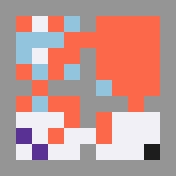

[1 8 8 8 8 7 8 6 1 1 1 1 8 8 9 8 7 3 1 1 1 8 8 8 7 8 1 1 1 1 8 6 9 2 8 3 9
 8 2 2 0 7 8 4 2 2 2 2 2 2 7 4 4 0 2 0 2 0 7 2 4 4 4 2 2 2 2]
{(1, 1): 1, (1, 2): 8, (1, 3): 8, (1, 4): 8, (1, 6): 8, (1, 7): 7, (1, 8): 8, (1, 9): 6, (2, 1): 1, (2, 2): 1, (2, 3): 1, (2, 4): 1, (2, 5): 8, (2, 6): 8, (2, 7): 9, (2, 8): 8, (2, 9): 7, (3, 1): 3, (3, 2): 1, (3, 3): 1, (3, 4): 1, (3, 6): 8, (3, 7): 8, (3, 8): 8, (3, 9): 7, (4, 1): 8, (4, 2): 1, (4, 3): 1, (4, 4): 1, (4, 6): 1, (4, 7): 8, (4, 8): 6, (4, 9): 9, (5, 2): 2, (5, 6): 8, (5, 7): 3, (5, 8): 9, (5, 9): 8, (6, 1): 2, (6, 2): 2, (6, 3): 0, (6, 4): 7, (6, 8): 8, (7, 1): 4, (7, 2): 2, (7, 3): 2, (7, 4): 2, (7, 6): 2, (7, 7): 2, (7, 8): 2, (7, 9): 7, (8, 1): 4, (8, 2): 4, (8, 3): 0, (8, 4): 2, (8, 5): 0, (8, 6): 2, (8, 7): 0, (8, 8): 7, (8, 9): 2, (9, 1): 4, (9, 2): 4, (9, 3): 4, (9, 4): 2, (9, 6): 2, (9, 7): 2, (9, 8): 2}


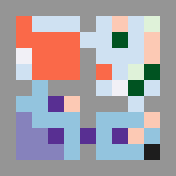

In [17]:
n_abs = 10
state_dim = 2
n_action = 4

visualization_map = dict([
    ('G', 0), # goal
    ('#', 1),
    *[(str(i), i + 2) for i in range(0, 100)],
])

def get_states(env):
    # get the whole state space
    states = []
    for i in range(env.size[0]):
        for j in range(env.size[1]):
                if env.is_valid_loc((i, j)):
                    states.append((i, j))
    infos = {'task_id': [0] * len(states)} 
    return states, infos

def get_img(env, abs_list):
    indices = np.zeros(env.size, dtype=np.int64)
    k = 0
    for i in range(env.size[0]):
        for j in range(env.size[1]):
            if (i, j) == env.goal:
                indices[i, j] = 0
            elif env.map[i][j] == '#':
                indices[i, j] = 1
            else:
                indices[i, j] = visualization_map[str(2 + abs_list[k])]
                k += 1

    img = drawer.draw(indices)
    return img

env = DiscreteGridWorld('fourroom', (1, 1), (9, 9))
decomposer = NMF(n_abs, solver='mu', beta_loss='kullback-leibler', random_state=0)

expert = CategoricalActorCriticNet(
    1,
    state_dim,
    n_action,
    FCBody(
        state_dim, 
        hidden_units=(16,)
    ),  
)
# load weight
weight_dict = expert.state_dict()
loaded_weight_dict = {k: v for k, v in torch.load(
    'log/grid.fourroom/fc_discrete.baseline/_/0.190228-203237/models/step-128000-mean-1.00',
    map_location=lambda storage, loc: storage)['network'].items()
    if k in weight_dict}
weight_dict.update(loaded_weight_dict)
expert.load_state_dict(weight_dict)


states, infos = get_states(env)                
print(states)
print('n_states:', len(states))
                
actions = expert(np.array(states), infos)['a'] # maybe take the whole distribution

img = get_img(env, actions.cpu().detach().numpy())
imshow(img)

pvs = F.softmax(expert.get_logits(np.array(states), infos), dim=1).cpu().detach().numpy()
#pvs = one_hot.encode(actions, n_action).cpu().detach().numpy()
abs_mat = decomposer.fit_transform(pvs)
policy_mat = decomposer.components_

abs_list = np.array(abs_mat).argmax(1)
print(abs_list)
abs_map = {s: i for s, i in zip(states, abs_list)}
print(abs_map)
fsave(abs_map, 'data/abs/grid/fourroom/prob.{}'.format(n_abs), 'pkl')

img = get_img(env, abs_list)
imshow(img)